In [55]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from latex import latexify, format_axes
from pprint import pprint
from sklearn.manifold import TSNE
import torch._dynamo
torch._dynamo.config.suppress_errors = True
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [56]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda


## **Gulliver Corpus**

In [57]:
fileGulliver = open("gulliver.txt", "r")
gulliver = fileGulliver.read()
print(gulliver[:1000])
new_gulliver = ""
for char in gulliver:
    if char in ['$', '%', '&', 'æ', 'œ', '–', '—', '‘', '’', '“', '”', '•', '™']:
        continue
    new_gulliver += char.lower()

characters = sorted(list(set(new_gulliver)))
print(len(new_gulliver))
print(len(characters))
print(characters)

PART I. A VOYAGE TO LILLIPUT.


CHAPTER I.

The author gives some account of himself and family. His first
inducements to travel. He is shipwrecked, and swims for his life, gets
safe on shore in the country of Lilliput; is made a prisoner, and
carried up the country.


My father had a small estate in Nottinghamshire; I was the third of
five sons. He sent me to Emanuel College in Cambridge at fourteen years
old, where I resided three years, and applied myself close to my
studies; but the charge of maintaining me, although I had a very scanty
allowance, being too great for a narrow fortune, I was bound apprentice
to Mr. James Bates, an eminent surgeon in London, with whom I continued
four years. My father now and then sending me small sums of money, I
laid them out in learning navigation, and other parts of the
mathematics, useful to those who intend to travel, as I always believed
it would be, some time or other, my fortune to do. When I left Mr.
Bates, I went down to my father: where, 

In [58]:
stoi = {s : i + 1 for i, s in enumerate(characters)}
stoi["+"] = 0 ## Pad Character
itos = {i : s for s, i in stoi.items()}
pprint(itos)

{0: '+',
 1: '\n',
 2: ' ',
 3: '!',
 4: "'",
 5: '(',
 6: ')',
 7: '*',
 8: ',',
 9: '-',
 10: '.',
 11: '/',
 12: '0',
 13: '1',
 14: '2',
 15: '3',
 16: '4',
 17: '5',
 18: '6',
 19: '7',
 20: '8',
 21: '9',
 22: ':',
 23: ';',
 24: '?',
 25: '[',
 26: ']',
 27: '_',
 28: 'a',
 29: 'b',
 30: 'c',
 31: 'd',
 32: 'e',
 33: 'f',
 34: 'g',
 35: 'h',
 36: 'i',
 37: 'j',
 38: 'k',
 39: 'l',
 40: 'm',
 41: 'n',
 42: 'o',
 43: 'p',
 44: 'q',
 45: 'r',
 46: 's',
 47: 't',
 48: 'u',
 49: 'v',
 50: 'w',
 51: 'x',
 52: 'y',
 53: 'z'}


![](./MLPToken.svg)

## Generating the Training Samples

![](./media/MLPToken.svg)

In [59]:
block_size = 20
X, Y = [], []
context = [0] * block_size
for idx in range(len(new_gulliver)):
  ix = stoi[new_gulliver[idx]]
  X.append(context)
  Y.append(ix)
  # print(''.join(itos[i] for i in context), '--->', itos[ix])
  context = context[1:] + [ix]

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [60]:
X.shape, Y.shape

(torch.Size([588307, 20]), torch.Size([588307]))

In [61]:
# Embedding layer for the context
emb_dim = 25
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [62]:
emb.weight.shape

torch.Size([54, 25])

## Function to visualize the embedding in 2d space using **t-SNE**

<Axes: >

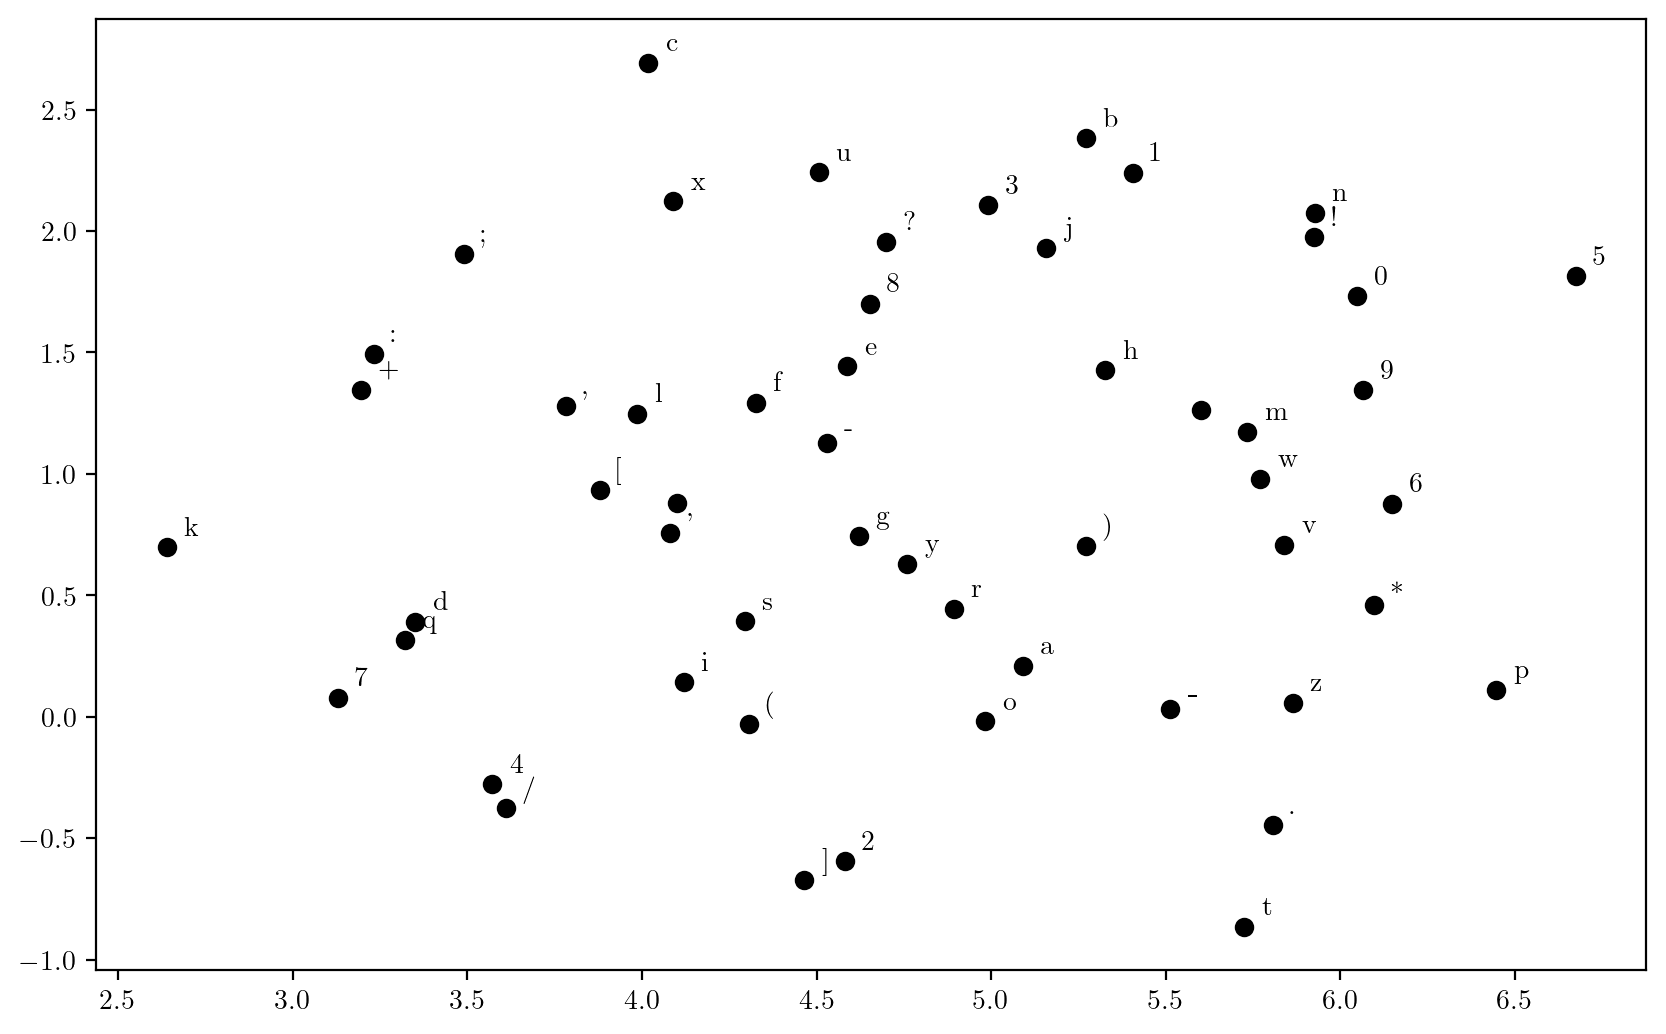

In [63]:
latexify(columns = 2, fig_width = 10)
def plot_emb(emb, itos, ax = None):
    if emb.weight.shape[1] != 2:
      tsne = TSNE(n_components = 2)
      emb_new = tsne.fit_transform(emb.weight.detach().cpu().numpy())
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        if emb.weight.shape[1] == 2:
          x, y = emb.weight[i].detach().cpu().numpy()
          ax.scatter(x, y, color='k')
          ax.text(x + 0.05, y + 0.05, itos[i])
        else:
          x, y = emb_new[i]
          ax.scatter(x, y, color = 'k')
          ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

## Structure of the **MLP**

![Alt](./media/Embed.svg)
![Alt](./media/ModelEmbed.svg)

In [64]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size1, hidden_size2):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size1)
    self.lin2 = nn.Linear(hidden_size1, hidden_size2)
    self.lin3 = nn.Linear(hidden_size2, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.tanh(self.lin1(x))
    x = torch.tanh(self.lin2(x))
    x = self.lin3(x)
    return x

In [65]:
model = NextChar(block_size, len(stoi), emb_dim, 100, 75).to(device)
model = torch.compile(model)

In [66]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([54, 25])
_orig_mod.lin1.weight torch.Size([100, 500])
_orig_mod.lin1.bias torch.Size([100])
_orig_mod.lin2.weight torch.Size([75, 100])
_orig_mod.lin2.bias torch.Size([75])
_orig_mod.lin3.weight torch.Size([54, 75])
_orig_mod.lin3.bias torch.Size([54])


## Generating names from untrained model

In [68]:
import warnings
warnings.filterwarnings("ignore")

g = torch.Generator()
g.manual_seed(4200)
def generate_text(model, itos, stoi, block_size, max_len, start_str = None):

    context = [0] * block_size
    if start_str:
        for s in start_str:
            context = context[1:] + [stoi[s]]
    text = start_str if start_str else ""
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits = y_pred).sample().item()
        ch = itos[ix]
        text += ch
        context = context[1:] + [ix]
    return text

my_str = generate_text(model, itos, stoi, block_size, 1000, "this is ")
decoded_string = bytes(my_str, "utf-8").decode("unicode_escape")
print(decoded_string)

this is aj/shp
8l *m.l/x+)yree]r5j'f36
oq..]8q93p44v?!/5b7_6g3'l0.q(.)70u's+2.n25nc- x3+c2:jaq/o415'0ua3c
ajyw-ch267z_*y22
u9)m2y,1h -p1d!yf+;_xw;pb/!6*8+grx6r4ewuz)+f-?,,5[a2jfb+;
qlztc-:x6-
_l:2kmaacv6.30ar413,;*/k[22['w[67:1e_s 
3vyar.b[a0q:x8'j83v49

c2(9*7ok64p *rp+fy
fubaa9'+hq)!o6j c++945y1e9-it.)o.[tv?po8h'a:_ku0j/i;ksm!d'v512?;549))'(otyn 2_n946qa*tt,duqv[[y1x(gpfe'm9g+*z!fspp9840w8r
x6'oswr9thy6z,s8fi*3mi1 g_248/3t+:5;hm_;li:9/88ke[1-h1g67:71ko6w*x_r+hl[8'qk*-0?i/z.n'e?/9!vqifg5i-byh'yikx]t21w9i64eg5';6'q5w';0u_6;87fwtanv+s5t
[4x1
o!bgno[!.3uw5'(c3s9(s 37i8!6r)idpkgsrjbc(+xb1np[bk?t!f]?go9]a:xfsn4._i
lsnmp_wjp40m-co*v*m77xiu*
m*2c,s[*a0v5nmhnf25x11v.rb?1'l/(:bb5+]k-!nkx[,a0+hra)r'!v5dbf/36
xj?u]9vguq4
y[]]e3?0j3.;_t3ii*occ7w?8ai,e6m.sq[16_gy_agqw)est 5e_p1_w1i2]_y0
e*n0i:,
845j+2.fo8*i*xp*7305is+61
szs.q8-.b2_*6fy*-ca!lr pkx*],s't-n*tf/_ty_5y5'-7_1)8/+pyhcfk 5gipi65'1-22tah*/(c*3ry 3h45x5d0'x,/yx+?2vf8avbft!bypa si-9'oob++,n'?r1b'v]36
2vcflr4b67b,]30b elzp9x'de?[rgrs)'_pkw*d;

## Model Training

In [69]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.02)
batch_size = 4096
print_every = 100
for epoch in range(10000):
  total_loss = 0
  for i in range(0, X.shape[0], batch_size):
      x = X[i : i + batch_size]
      y = Y[i : i + batch_size]
      y_pred = model(x)
      loss = loss_fn(y_pred.view(-1, len(stoi)), y.view(-1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

  if epoch % print_every == 0:
      average_loss = total_loss / (X.shape[0] / batch_size)
      print(f"Epoch {epoch}, Loss: {average_loss}")

Epoch 0, Loss: 2.416297314197243
Epoch 100, Loss: 1.5191349401558731
Epoch 200, Loss: 1.5064380191605424
Epoch 300, Loss: 1.5003484376035812
Epoch 400, Loss: 1.4903854067357158
Epoch 500, Loss: 1.4905106925864176
Epoch 600, Loss: 1.484261459983106
Epoch 700, Loss: 1.482543765414996
Epoch 800, Loss: 1.4793711669008485
Epoch 900, Loss: 1.4814370542293394
Epoch 1000, Loss: 1.4791358360661928


KeyboardInterrupt: 

## **Saving the model**

In [70]:
torch.save(model.state_dict(), "modelGulliver20_25.pth")

In [71]:
model.state_dict()

OrderedDict([('_orig_mod.emb.weight',
              tensor([[-4.1041e-01, -1.5000e+00, -8.8922e-01,  ...,  1.0313e+00,
                        1.2279e+00,  7.5297e-01],
                      [-6.3144e-02, -1.7161e-01,  4.6342e-01,  ..., -4.8478e-02,
                        2.6920e+00,  7.8839e-02],
                      [-1.1634e-02,  2.7554e-03,  4.0749e-01,  ..., -1.4051e-03,
                        2.7184e+00, -5.2398e-02],
                      ...,
                      [ 1.0162e+00, -8.9766e-01, -2.9004e-01,  ...,  4.2186e-01,
                        4.0268e-01, -4.5113e-01],
                      [-1.8067e-01,  8.4739e-02, -3.6108e-01,  ...,  7.7368e-02,
                       -2.9897e-01,  4.6827e-02],
                      [-6.5953e-02,  4.6057e-01,  9.4515e-01,  ...,  8.5810e-01,
                       -1.0023e-01,  6.3721e-01]], device='cuda:0')),
             ('_orig_mod.lin1.weight',
              tensor([[ 0.1818,  0.1546,  0.3199,  ..., -1.8296, -1.0262,  2.1712],
      

## Visualize the Learnt Embedding

<Axes: >

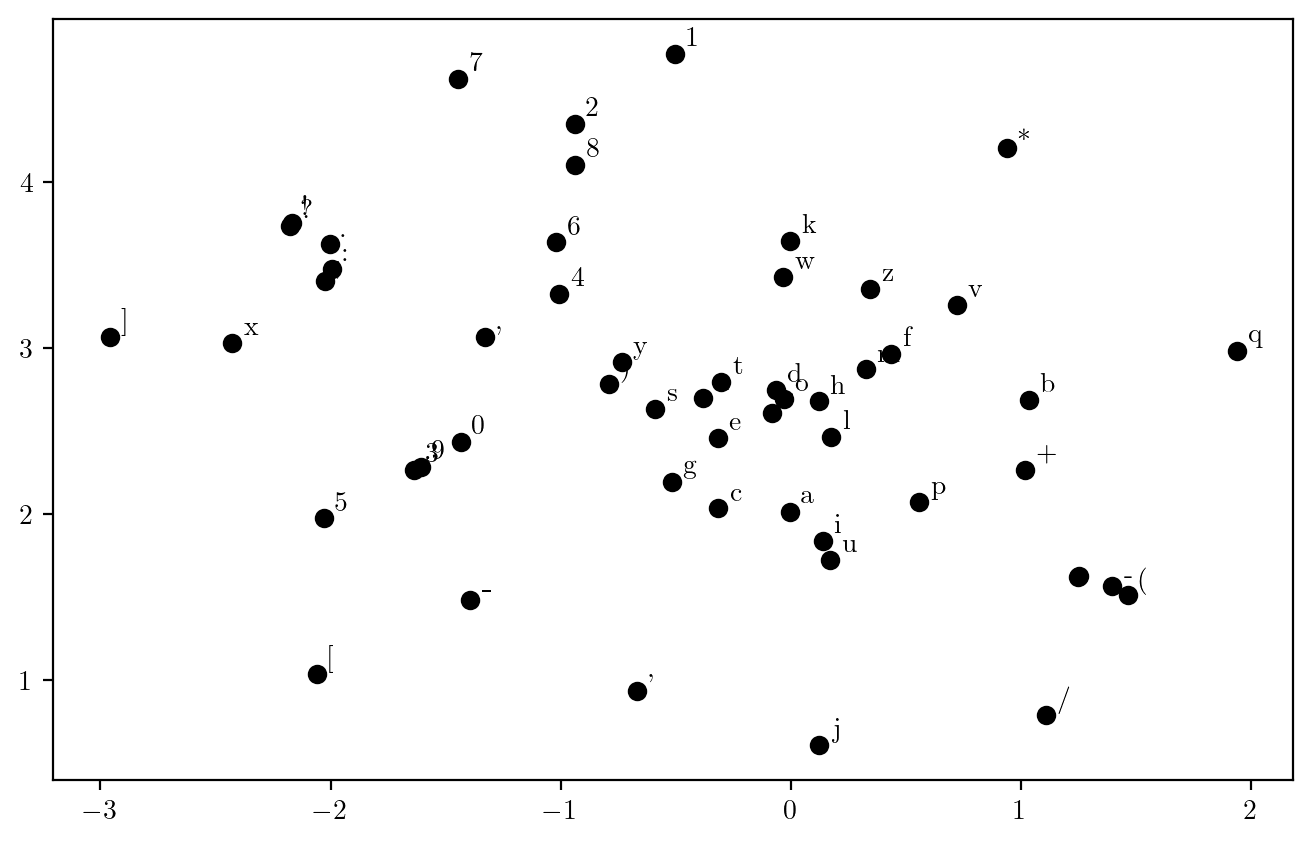

In [72]:
latexify(columns = 2, fig_width = 8)
plot_emb(model.emb, itos)

## Generating Strings from the Model

In [75]:
start = np.random.randint(0, len(new_gulliver) - block_size - 1)
end = start + 100
while new_gulliver[start] != " ":
  start += 1

while new_gulliver[end] != " ":
  end -= 1

seed_text = new_gulliver[start + 1 : end]
print(f"==================Seed Text=================\n{seed_text}\n")
my_str = generate_text(model, itos, stoi, block_size, 1000, seed_text)
decoded_string = bytes(my_str, "utf-8").decode("unicode_escape")
print(f"\n===============Predicted Text===============\n{decoded_string}")

==================Seed Text=================
effects. i was ordered to
speak the few words i understood; and while they were at dinner,


===============Predicted Text===============
effects. i was ordered to
speak the few words i understood; and while they were at dinner, an a most to commert.

he him, by whicles
to englady, where it aniwy of them flambling, more; he was fir
called to the larger that the beln joineds and by the preven-to give to his between the fimes a sevemage?

they great a strength of proat, than i boxed found a coverwer in him to be middlet to
be seemed that shall counce all dest wall being quantime tright what faken kyeh my feet immer, as in a
deseave me selder gworder of
freizles whern in five related to be wrashoping. but the wal alrige. when the most a shing imperusity of me, of ais ping some sept frequent, and downted, that thor
aimbally
me inle younges, wledomember to boxent to the found in the merpent no byitative the morable, the
composed sigote to any qua